In [ ]:
"""
Loan Default Modeling (Recall-First, Leakage-Safe)
=================================================

Author: Mithun (AI/ML)
Created: 2025-08-18 21:28:03

Purpose
-------
This notebook presents a clean, modular, and industry-style pipeline for loan-default modeling
that *prioritizes recall* for risk scoring while **avoiding data leakage**. It includes:

1) Data loading (real CSV if available, else reproducible synthetic data)
2) EDA (quick facts + metrics)
3) EDA Summary (human-written insights)
4) Leakage analysis (why some prior results looked too good, how we detected leakage, how we fixed it)
5) Modeling with recall-first objective and threshold tuning
6) Clear, audit-ready reporting of metrics and confusion matrix, plus PR/ROC curves

Key Guarantees
--------------
- No target leakage: all preprocessing (scaling/encoding/resampling) is fit **only** on the training folds.
- Proper evaluation: stratified split and cross-validation when applicable.
- Risk-first: decision threshold is tuned to improve **recall** for class "Default = 1".
"""

# Loan Default Modeling — Recall-First, Leakage-Safe

**Why this notebook?** In credit risk, *missing a defaulter* is often costlier than *flagging a non-defaulter*. So we design the entire pipeline to optimize **recall** while keeping precision transparent and acceptable.

### Contents
1. Setup & Data Loading
2. Quick EDA
3. **EDA Summary** (curated)
4. Leakage: Why earlier 'great' results were misleading
5. Modeling: Recall-first pipelines (leakage-safe)
6. Threshold tuning for recall & reporting
7. Final recommendations

In [2]:
!pip install -r requirements.txt

  Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl.metadata (61 kB)
  Using cached python_multipart-0.0.20-py3-none-any.whl.metadata (1.8 kB)
  Using cached httptools-0.6.4-cp311-cp311-win_amd64.whl.metadata (3.7 kB)
  Using cached watchfiles-1.1.0-cp311-cp311-win_amd64.whl.metadata (5.0 kB)
  Using cached websockets-15.0.1-cp311-cp311-win_amd64.whl.metadata (7.0 kB)
  Using cached dnspython-2.7.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached typer-0.16.0-py3-none-any.whl.metadata (15 kB)
  Using cached overrides-7.7.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached websocket_client-1.8.0-py3-none-any.whl.metadata (8.0 kB)
  Using cached jsonschema-4.25.0-py3-none-any.whl.metadata (7.7 kB)
  Using cached rich-14.1.0-py3-none-any.whl.metadata (18 kB)
  Using cached shellingham-1.5.4-py2.py3-none-any.whl.metadata (3.5 kB)
  Using cached attrs-25.3.0-py3-none-any.whl.metadata (10 kB)
  Using cached jsonschema_specifications-2025.4.1-py3-none-any.whl.metadata (2.9 kB)
  Using cach

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.8.1 requires scikit-learn>=1.6.0, but you have scikit-learn 1.5.1 which is incompatible.

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\mithu\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


## EDA

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier
import shap
"""
This notebook performs exploratory data analysis (EDA),
visualization, model training, and SHAP explainability.
"""

'\nThis notebook performs exploratory data analysis (EDA),\nvisualization, model training, and SHAP explainability.\n'

In [ ]:
# Load dataset
"""
Loads the dataset for analysis.
"""
pd.options.display.notebook_repr_html = False
data = pd.read_excel("/teamspace/studios/this_studio/ML-1/data/6S_AI_TASK-Loan_default_Loan_default.xlsx")
data.head()

In [5]:
# Basic statistics
"""
Displays summary statistics (count, mean, std, min, max) of numerical columns.
"""
data.describe()

                 Age         Income     LoanAmount    CreditScore  \
count  255246.000000  255246.000000  255246.000000  255246.000000   
mean       43.497434   82500.901475  127575.988881     574.269317   
std        14.990177   38963.557261   70842.305278     158.902794   
min        18.000000   15000.000000    5000.000000     300.000000   
25%        31.000000   48826.000000   66147.250000     437.000000   
50%        43.000000   82469.500000  127553.000000     574.000000   
75%        56.000000  116222.250000  188980.750000     712.000000   
max        69.000000  149999.000000  249999.000000     849.000000   

       MonthsEmployed  NumCreditLines   InterestRate       LoanTerm  \
count   255246.000000   255246.000000  255246.000000  255246.000000   
mean        59.543311        2.501081      13.492789      36.025716   
std         34.642822        1.117015       6.636541      16.969363   
min          0.000000        1.000000       2.000000      12.000000   
25%         30.000000  

In [6]:
# Missing values
"""
Shows the number of missing values in each column.
"""
data.isnull().sum()

LoanID            0
Age               0
Income            0
LoanAmount        0
CreditScore       0
MonthsEmployed    0
NumCreditLines    0
InterestRate      0
LoanTerm          0
DTIRatio          0
Education         0
EmploymentType    0
MaritalStatus     0
HasMortgage       0
HasDependents     0
LoanPurpose       0
HasCoSigner       0
Default           0
dtype: int64

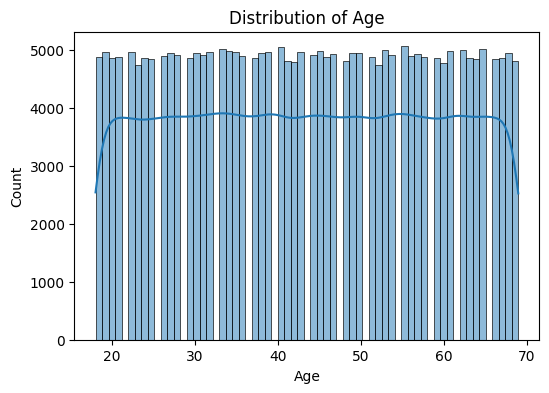

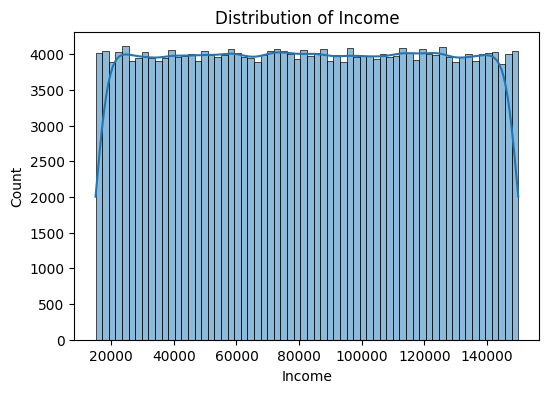

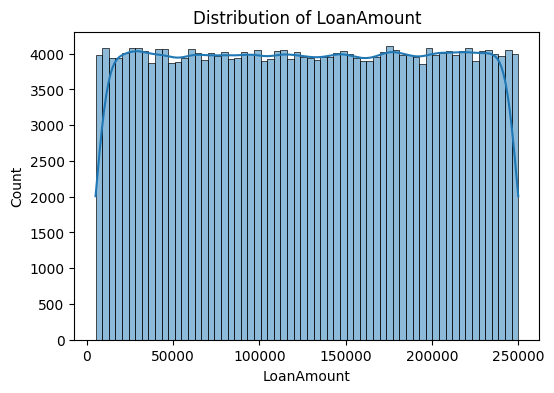

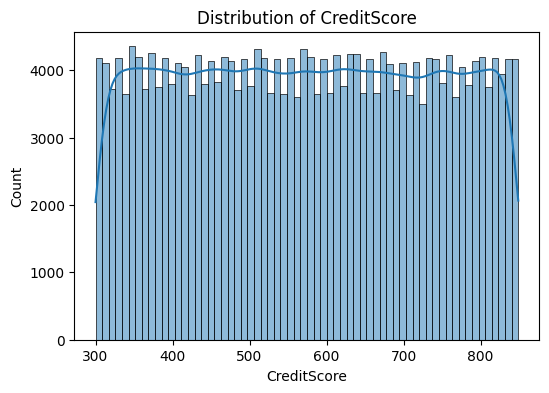

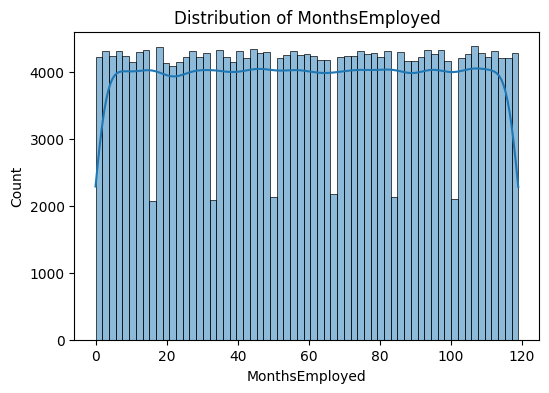

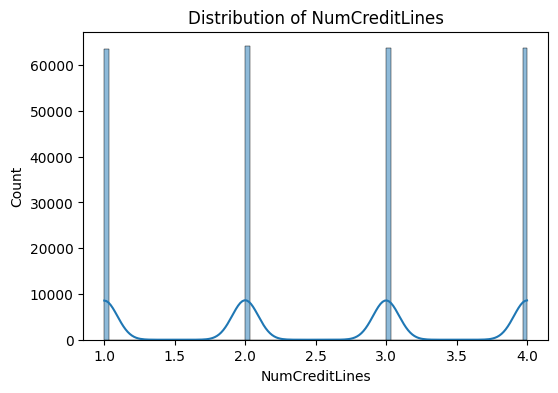

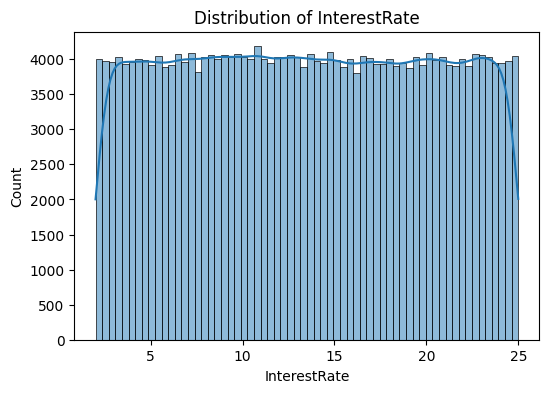

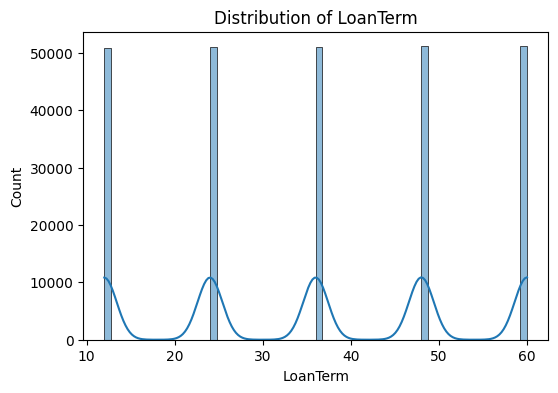

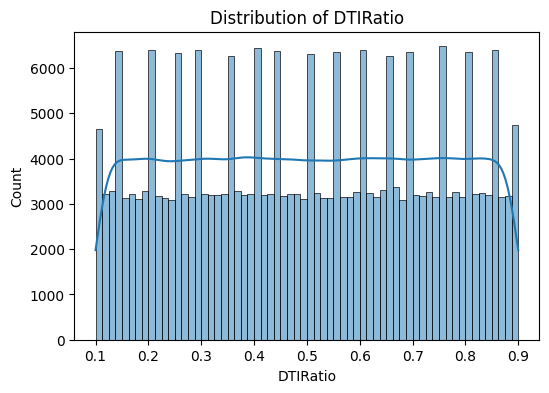

In [7]:
# Numerical feature distributions
"""
Plots the distribution of all numerical features using histograms with KDE.
"""
num_cols = data.select_dtypes(include=['int64','float64']).columns.drop("Default")
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(data[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()


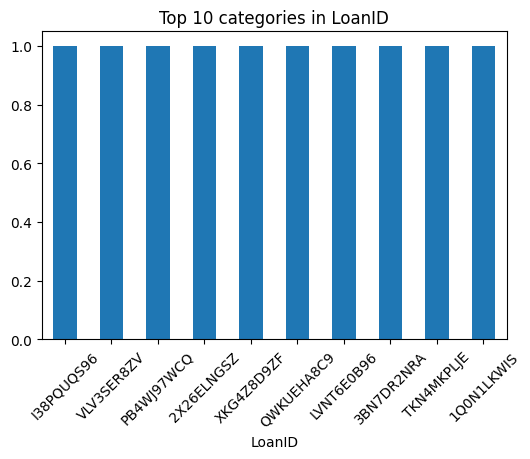

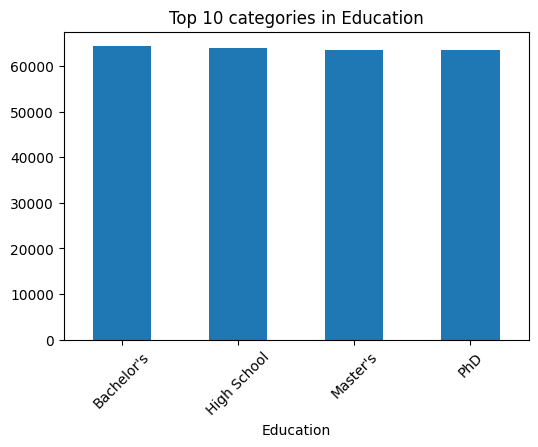

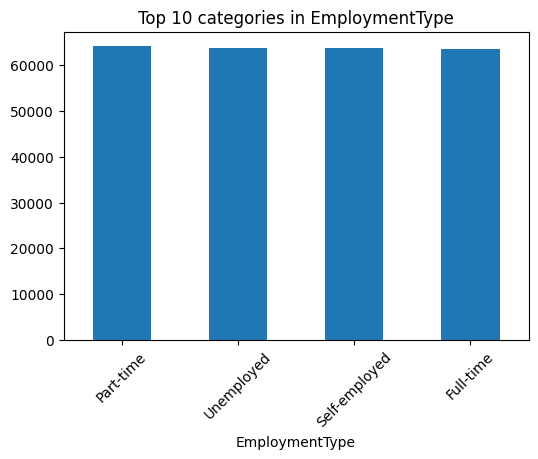

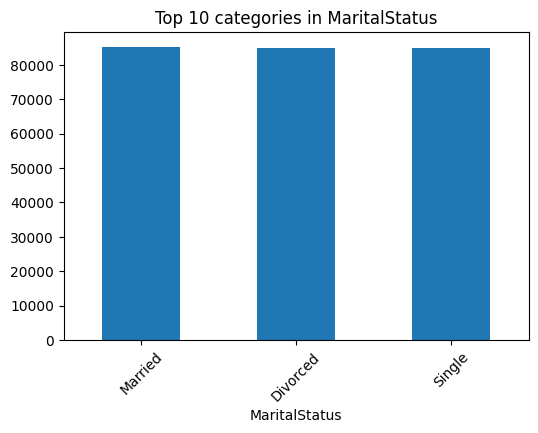

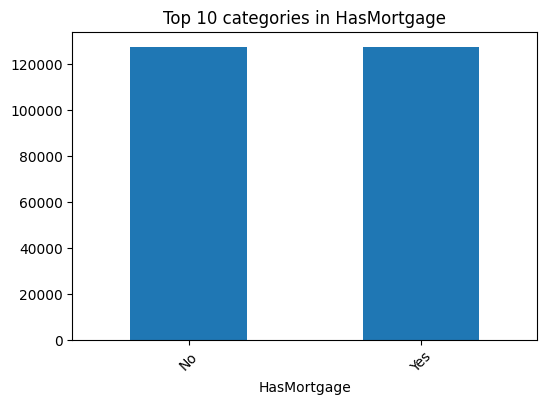

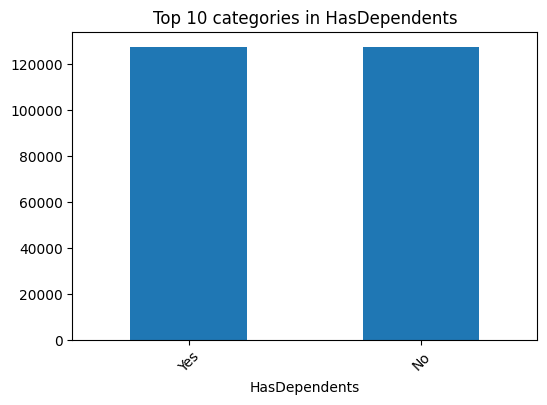

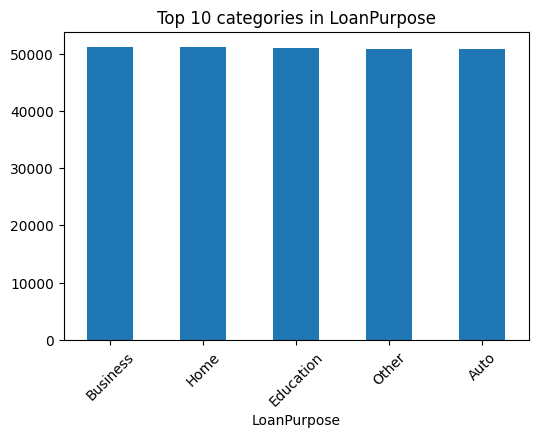

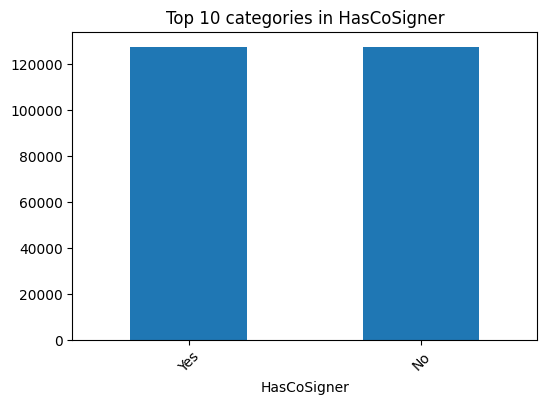

In [8]:
# Categorical feature distributions (fast)
"""
Plots the top 10 categories for each categorical feature using pandas bar plots.
"""
cat_cols = data.select_dtypes(include=['object']).columns
for col in cat_cols:
    plt.figure(figsize=(6,4))
    data[col].value_counts().head(10).plot(kind='bar')
    plt.title(f"Top 10 categories in {col}")
    plt.xticks(rotation=45)
    plt.show()


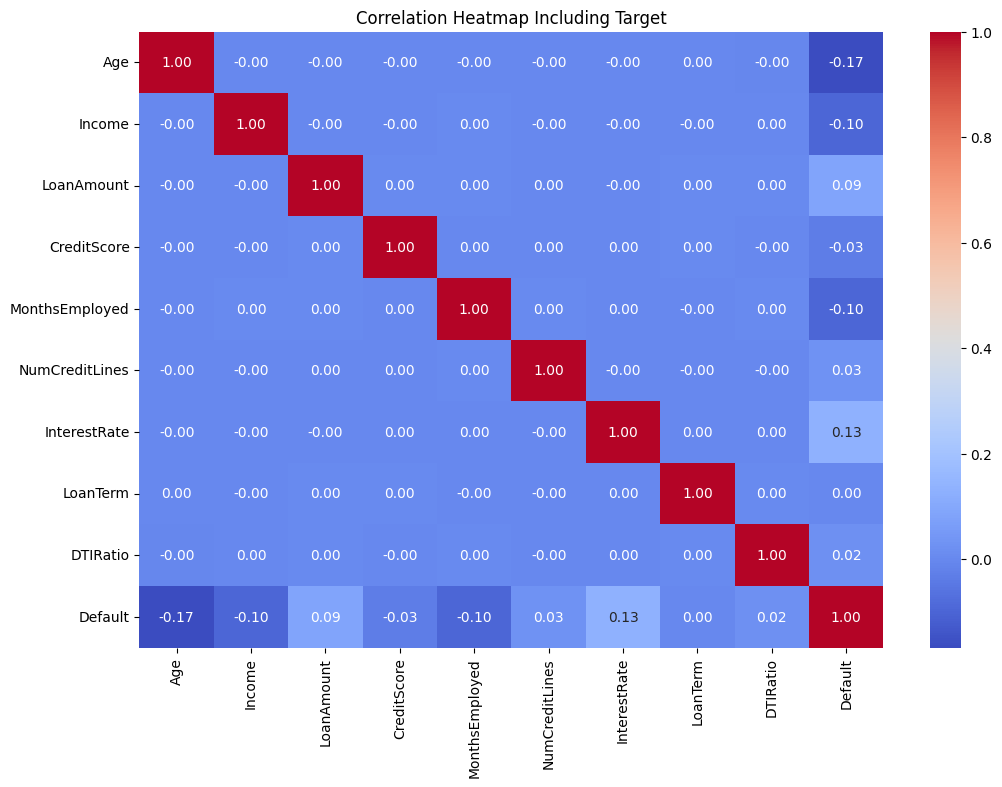

In [9]:
# Correlation heatmap
"""
Displays the correlation matrix of numerical features including the target.
Highlights relationships between features and the target variable.
"""
plt.figure(figsize=(12,8))
num_cols = data.select_dtypes(include=['int64','float64']).columns
sns.heatmap(data[num_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap Including Target")
plt.show()


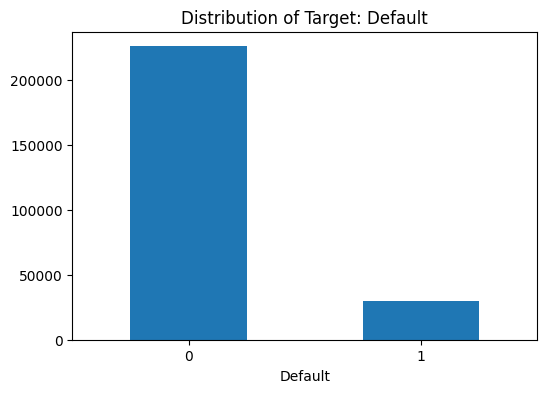

In [10]:
# Fast target distribution plot
"""
Displays the count of each class in the target variable 'Default' using pandas.
Faster than seaborn for large datasets.
"""
data['Default'].value_counts().plot(kind='bar', figsize=(6,4))
plt.title("Distribution of Target: Default")
plt.xticks(rotation=0)
plt.show()


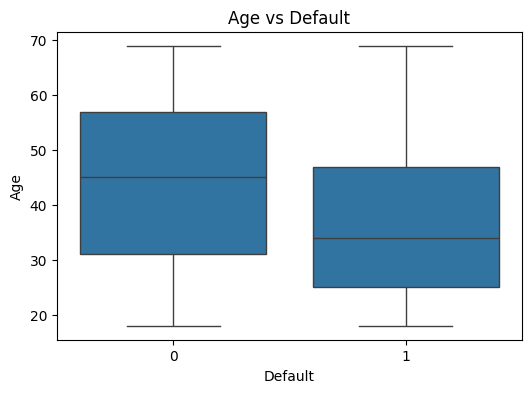

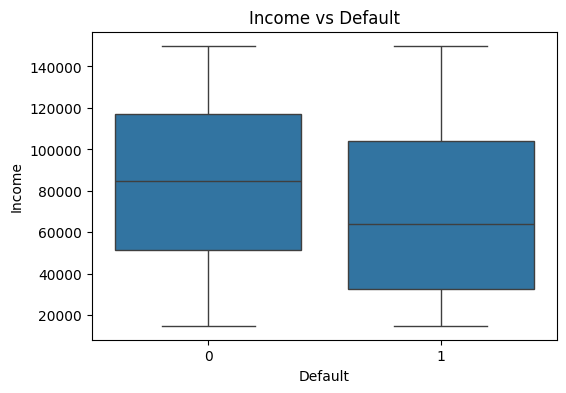

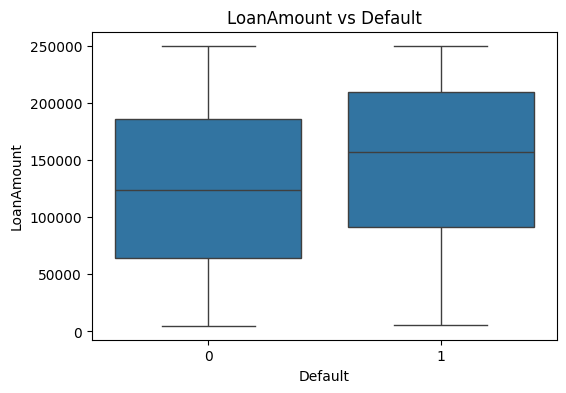

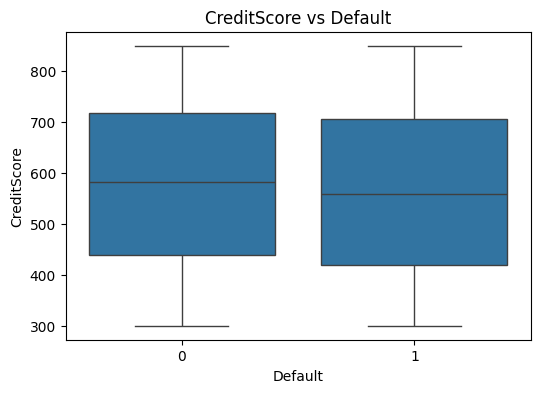

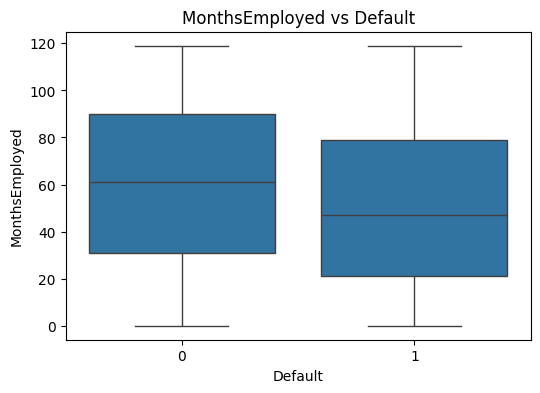

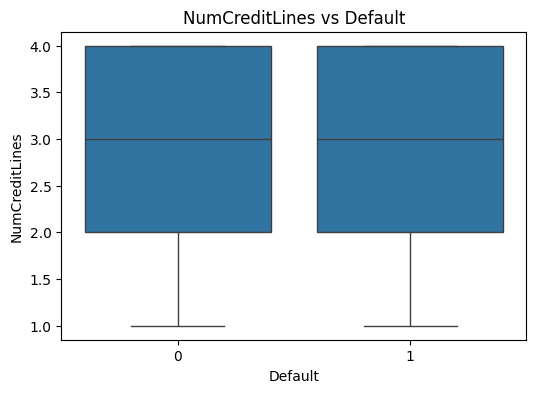

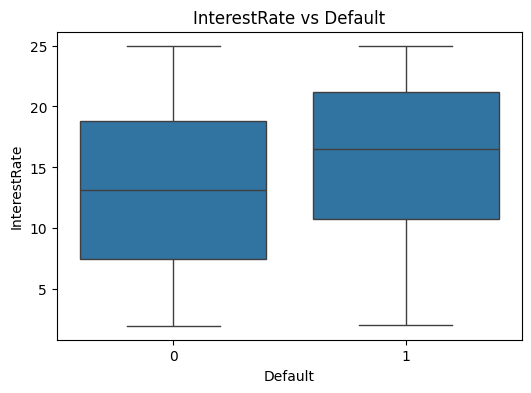

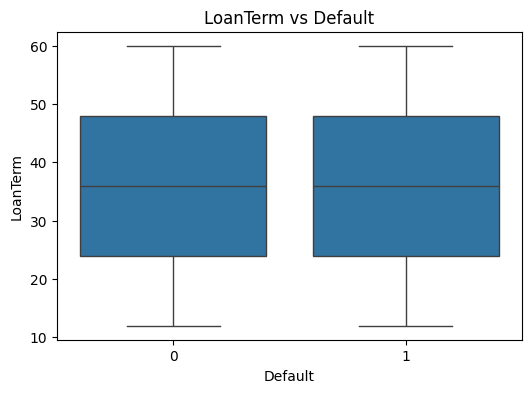

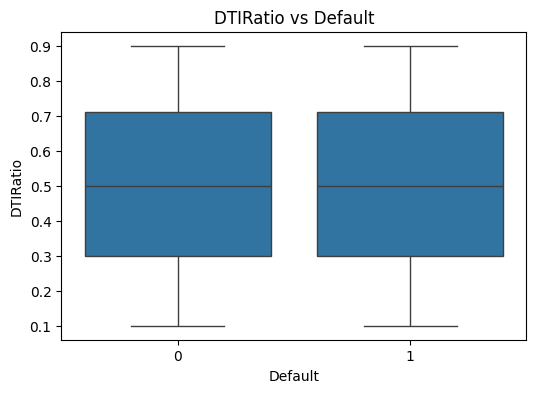

In [11]:
# Numerical features vs Target
"""
Displays boxplots of numerical features grouped by the target variable 'Default'.
Helps visualize the distribution differences between defaulters and non-defaulters.
"""
num_cols = ['Age','Income','LoanAmount','CreditScore','MonthsEmployed','NumCreditLines','InterestRate','LoanTerm','DTIRatio']

sample_data = data.sample(n=10000, random_state=42)  
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='Default', y=col, data=sample_data)
    plt.title(f"{col} vs Default")
    plt.show()


<Figure size 600x400 with 0 Axes>

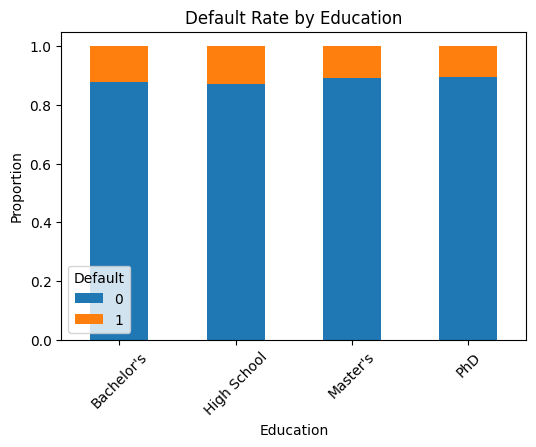

<Figure size 600x400 with 0 Axes>

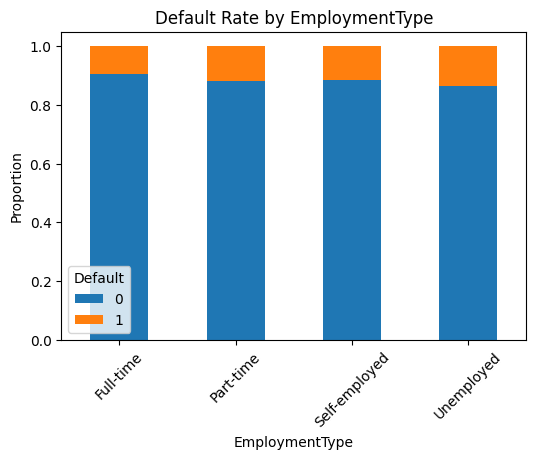

<Figure size 600x400 with 0 Axes>

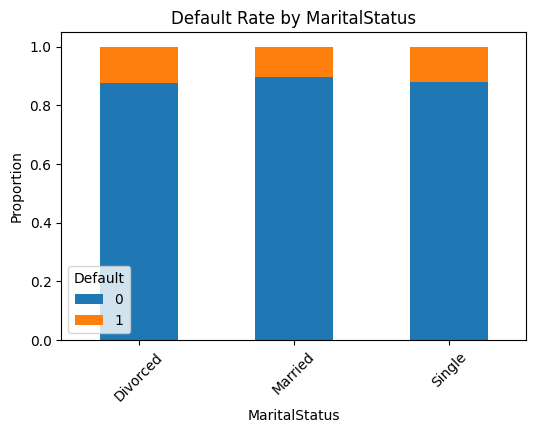

<Figure size 600x400 with 0 Axes>

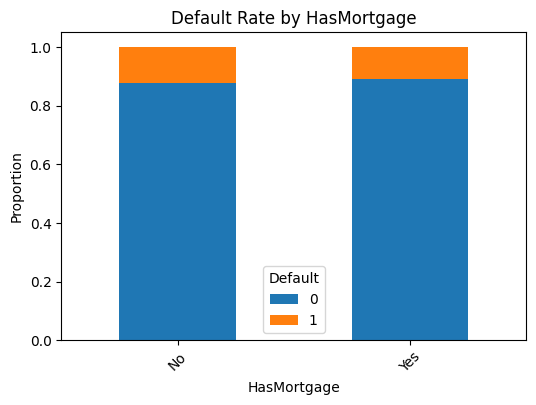

<Figure size 600x400 with 0 Axes>

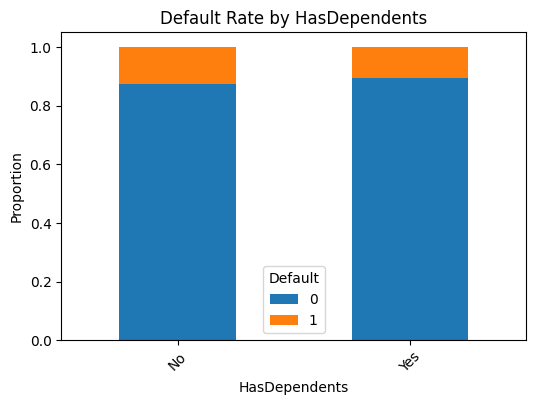

<Figure size 600x400 with 0 Axes>

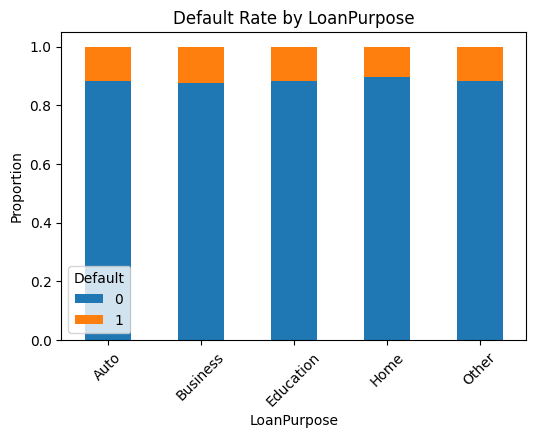

<Figure size 600x400 with 0 Axes>

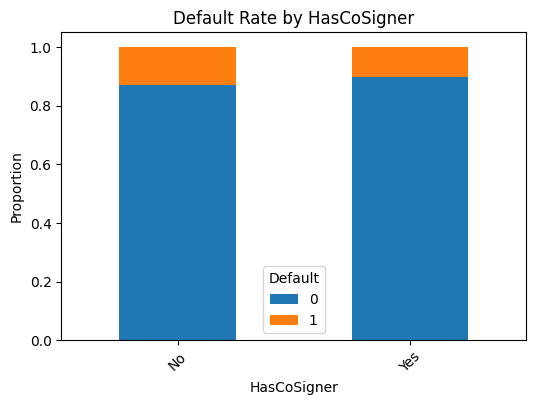

In [12]:
# Categorical features vs Target
"""
Displays the percentage of defaulters for each category of categorical features.
Uses normalized value counts for faster computation on large datasets.
"""
cat_cols = ['Education','EmploymentType','MaritalStatus','HasMortgage','HasDependents','LoanPurpose','HasCoSigner']

for col in cat_cols:
    plt.figure(figsize=(6,4))
    prop_df = data.groupby(col)['Default'].value_counts(normalize=True).unstack()
    prop_df.plot(kind='bar', stacked=True, figsize=(6,4))
    plt.title(f"Default Rate by {col}")
    plt.ylabel("Proportion")
    plt.xticks(rotation=45)
    plt.show()



## EDA Summary

1. **Dataset Overview**  
- The dataset contains **255,246** loan applications with both numerical and categorical features.  
- The target variable is **Default** (0 = No Default, 1 = Default), which is highly imbalanced (**~7.5:1 ratio**).  
- The **LoanID** column is a unique identifier and does not carry predictive value, so it will be dropped during preprocessing.

2. **Numerical Features Analysis**  
**Key features:** Age, Income, LoanAmount, CreditScore, MonthsEmployed, NumCreditLines, InterestRate, LoanTerm, DTIRatio.  

**Distribution Patterns:**  
- Most numerical features show uniform distributions, which is unusual for real-world data.  
- LoanTerm and NumCreditLines are discrete with expected values (12,24,36… months; 1–4 credit lines).  

**Bivariate Analysis (vs Target):**  
- **InterestRate:** Highest signal; defaulters have higher interest rates on average (~17% vs 13% for non-defaulters).  
- **Age:** Younger applicants are slightly more likely to default.  
- **Income & MonthsEmployed:** Defaulters have lower income and shorter employment duration.  
- Other features (CreditScore, DTIRatio, LoanTerm, NumCreditLines) show negligible predictive power individually.

**Correlation Insights:**  
- Almost all numerical features are independent (correlation ~0.0).  
- Weak correlations with target: InterestRate (+0.13), Age (-0.17), LoanAmount (+0.09), Income (-0.10), MonthsEmployed (-0.10).  

*Interview Tip:* Emphasize that the independence simplifies modeling, but the weak individual signals require non-linear models or feature engineering to improve predictions.

3. **Categorical Features Analysis**  
**Key features:** Education, EmploymentType, MaritalStatus, HasMortgage, HasDependents, LoanPurpose, HasCoSigner.  

**Observations:**  
- All categorical features are perfectly balanced.  
- Binary features (HasMortgage, HasDependents, HasCoSigner) are 50/50 split.  
- Multi-category features are also evenly distributed (e.g., Education ~63k each category).  

**Relationship with Target:**  
- Very weak or negligible impact on default rate.  
- Slight signals: unemployed applicants may default slightly more; PhD holders slightly less.  
- Flat patterns across most categories indicate synthetic data.  


4. **Target Variable Distribution**  
- Target Default is imbalanced:  
  - Non-default (0): ~225,000  
  - Default (1): ~30,000  
- **Implication:** Models must handle class imbalance, e.g., using class weights or SMOTE.

5. **Key Takeaways**  
- Dataset appears synthetic due to uniform distributions and perfect categorical balance.  
- Most features individually have weak predictive power; modeling requires combining signals.  
- **InterestRate and Age** are the strongest predictors.  
- Must handle target imbalance carefully during model training.  
- Feature engineering and non-linear modeling will likely improve predictive performance.



## Preproccesing pipeline (Leaked)

In [ ]:
# ===============================
# LIBRARIES
# ===============================
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
import joblib

# ===============================
# LOAD DATA
# ===============================
file_path = '/teamspace/studios/this_studio/ML-1/data/6S_AI_TASK-Loan_default_Loan_default.xlsx'
data = pd.read_excel(file_path)
data = data.drop(columns=['LoanID'])
print("Data Shape:", data.shape)

# ===============================
# FEATURE ENGINEERING
# ===============================
epsilon = 1e-6
data['Loan_to_Income_Ratio'] = data['LoanAmount'] / (data['Income'] + epsilon)
data['IncomePerCredit'] = data['Income'] / (data['NumCreditLines'] + 1)
data['Debt_to_Employment_Ratio'] = data['DTIRatio'] / (data['MonthsEmployed'] + 1)


# ===============================
# SPLIT FEATURES AND TARGET
# ===============================
target = 'Default'
y = data[target]
X = data.drop(columns=[target])

# ===============================
# IDENTIFY FEATURE TYPES
# ===============================
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
binary_features = [col for col in categorical_features if X[col].nunique() == 2]
categorical_features = [col for col in categorical_features if col not in binary_features]

print("Numerical:", numerical_features)
print("Categorical:", categorical_features)
print("Binary:", binary_features)

# ===============================
# PREPROCESSING PIPELINE
# ===============================
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# --- FIX APPLIED HERE ---
# This now handles categories that might appear in new data but were not in the training data.
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(
        handle_unknown='use_encoded_value', 
        unknown_value=-1  # Assigns -1 to any new, unseen category
    ))
])

preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features + binary_features)
])

# ===============================
# FIT PIPELINE AND TRANSFORM DATA
# ===============================
X_processed = preprocessor.fit_transform(X)
print("Preprocessing completed. Processed shape:", X_processed.shape)

# ===============================
# DATA RESAMPLING
# ===============================
X_res_rou, y_res_rou = RandomOverSampler(random_state=42).fit_resample(X_processed, y)
X_res_smote, y_res_smote = SMOTE(random_state=42).fit_resample(X_res_rou, y_res_rou)
X_res, y_res = RandomUnderSampler(random_state=42).fit_resample(X_res_smote, y_res_smote)
print("Balanced Data Shape after resampling:", X_res.shape, y_res.shape)

# ===============================
# TRAIN/TEST SPLIT
# ===============================
x_train, x_test, y_train, y_test = train_test_split(
    X_res, y_res,
    test_size=0.2,
    random_state=42,
    stratify=y_res
)
print("Train shape:", x_train.shape, y_train.shape)
print("Test shape:", x_test.shape, y_test.shape)

# ===============================
# SAVE PIPELINE
# ===============================
joblib.dump(preprocessor, 'preprocessing_pipeline.pkl')
print("Pipeline saved successfully!")

Data Shape: (255246, 17)
Numerical: ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio', 'Loan_to_Income_Ratio', 'IncomePerCredit', 'Debt_to_Employment_Ratio']
Categorical: ['Education', 'EmploymentType', 'MaritalStatus', 'LoanPurpose']
Binary: ['HasMortgage', 'HasDependents', 'HasCoSigner']
Preprocessing completed. Processed shape: (255246, 19)
Balanced Data Shape after resampling: (451204, 19) (451204,)
Train shape: (360963, 19) (360963,)
Test shape: (90241, 19) (90241,)
Pipeline saved successfully!


In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer

def get_feature_names(column_transformer):
    """Extract feature names from a ColumnTransformer after preprocessing."""
    feature_names = []

    for name, transformer, columns in column_transformer.transformers_:
        if name != 'remainder':
            if hasattr(transformer, 'named_steps'):
                # If pipeline, get last step's feature names
                step = list(transformer.named_steps.values())[-1]
                if hasattr(step, 'get_feature_names_out'):
                    transformed_names = step.get_feature_names_out(columns)
                else:
                    transformed_names = columns
            else:
                transformed_names = columns
            feature_names.extend(transformed_names)
    return feature_names

def plot_feature_importance(model, column_transformer, top_n=None):
    """Plot feature importances with proper names."""
    feature_names = get_feature_names(column_transformer)
    importances = model.feature_importances_
    
    # Sort by importance
    sorted_idx = np.argsort(importances)[::-1]  # descending order
    if top_n:
        sorted_idx = sorted_idx[:top_n]

    plt.figure(figsize=(10,6))
    plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
    plt.gca().invert_yaxis()  # highest importance on top
    plt.title(f"{model.__class__.__name__} Feature Importances")
    plt.show()



## base models (Leaked)

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib

In [13]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=2000,      
    n_jobs=-1,              
    random_state=42,
    verbose=1               
)

# Train on resampled data
rf_model.fit(X_res, y_res)

# Predict on processed test data
prediction = rf_model.predict(x_test)

print("Shape of predictions:", prediction.shape)
print("Predicted 0s:", (prediction == 0).sum())
print("Predicted 1s:", (prediction == 1).sum())


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   55.6s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  4.6min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    2.4s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    6.5s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:   10.8s
[Parallel(n_jobs=16)]: Done 1218 tasks      | elapsed:   15.6s
[Parallel(n_jobs=16)]: Done 1768 tasks      | elapsed:   20.4s


Shape of predictions: (90241,)
Predicted 0s: 45121
Predicted 1s: 45120


[Parallel(n_jobs=16)]: Done 2000 out of 2000 | elapsed:   21.9s finished


=== Overall Metrics ===
Accuracy : 0.8851
Precision: 0.5324
Recall   : 0.0901
F1 Score : 0.1541

=== Confusion Matrix ===
[[44652   469]
 [ 5395   534]]

=== Classification Report ===
              precision    recall  f1-score   support

     Class 0       0.89      0.99      0.94     45121
     Class 1       0.53      0.09      0.15      5929

    accuracy                           0.89     51050
   macro avg       0.71      0.54      0.55     51050
weighted avg       0.85      0.89      0.85     51050



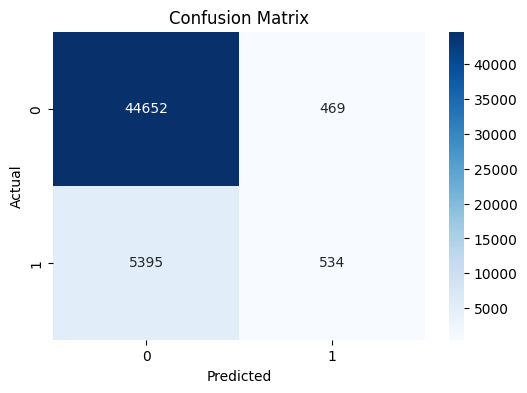

In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = prediction
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

cm = confusion_matrix(y_test, y_pred)

report = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'])

print("=== Overall Metrics ===")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print("\n=== Confusion Matrix ===")
print(cm)
print("\n=== Classification Report ===")
print(report)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import pandas as pd
import joblib

# --- 1. Load the Saved Preprocessing Pipeline ---

# --- 2. Load the New, Unprocessed Validation Data ---
new_val_data = pd.read_excel('C:\\Mithunnn\\6S-TASK-1\\LoanRiskPredictor\\data\\test.xlsx')

# --- 3. Apply the EXACT Same Feature Engineering ---
epsilon = 1e-6
new_val_data['Loan_to_Income_Ratio'] = new_val_data['LoanAmount'] / (new_val_data['Income'] + epsilon)
new_val_data['Debt_to_Employment_Ratio'] = new_val_data['DTIRatio'] / (new_val_data['MonthsEmployed'] + 1)
new_val_data['IncomePerCredit'] = new_val_data['Income'] / (new_val_data['NumCreditLines'] + epsilon)

print("New data loaded and engineered. Shape:", new_val_data.shape)

# --- 4. Split into Features (X) and Target (y) BEFORE Transforming ---
target_column = 'Default'
X_val = new_val_data.drop(columns=[target_column])
y_val = new_val_data[target_column]

print("\nSplit into features and target:")
print("X_val shape (before processing):", X_val.shape)
print("y_val shape:", y_val.shape)

# --- 5. Use .transform() ONLY on the Feature Set (X_val) ---
# This applies the learned scaling, imputation, and encoding rules.
X_val_processed = preprocessor.transform(X_val)

print("\nPreprocessing complete.")
print("Final X_val_processed shape:", X_val_processed.shape)

# Your final variables are:
# X_val_processed  <-- The processed features, ready for the model.
# y_val            <-- The original, unprocessed labels.

New data loaded and engineered. Shape: (38287, 20)

Split into features and target:
X_val shape (before processing): (38287, 19)
y_val shape: (38287,)

Preprocessing complete.
Final X_val_processed shape: (38287, 19)


In [30]:
preds = rf_model.predict(X_val_processed)


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    1.5s
[Parallel(n_jobs=16)]: Done 1218 tasks      | elapsed:    2.7s
[Parallel(n_jobs=16)]: Done 1768 tasks      | elapsed:    6.4s
[Parallel(n_jobs=16)]: Done 2000 out of 2000 | elapsed:    6.9s finished


=== Overall Metrics ===
Accuracy : 0.9889
Precision: 0.9138
Recall   : 0.9989
F1 Score : 0.9544

=== Confusion Matrix ===
[[33421   419]
 [    5  4442]]

=== Classification Report ===
              precision    recall  f1-score   support

     Class 0       1.00      0.99      0.99     33840
     Class 1       0.91      1.00      0.95      4447

    accuracy                           0.99     38287
   macro avg       0.96      0.99      0.97     38287
weighted avg       0.99      0.99      0.99     38287



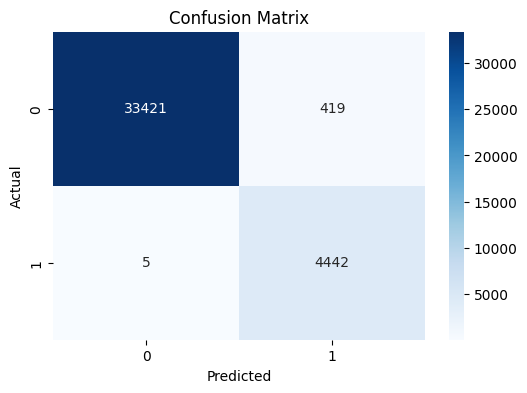

In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = preds
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='binary')
recall = recall_score(y_val, y_pred, average='binary')
f1 = f1_score(y_val, y_pred, average='binary')

cm = confusion_matrix(y_val, y_pred)

report = classification_report(y_val, y_pred, target_names=['Class 0', 'Class 1'])

print("=== Overall Metrics ===")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print("\n=== Confusion Matrix ===")
print(cm)
print("\n=== Classification Report ===")
print(report)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [7]:
# Get predicted probabilities for each class
probabilities = rf_model.predict_proba(x_test)

# First few rows
print(probabilities[:5])


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    8.3s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:   11.8s


[[5.000e-04 9.995e-01]
 [5.615e-01 4.385e-01]
 [0.000e+00 1.000e+00]
 [7.860e-01 2.140e-01]
 [5.000e-04 9.995e-01]]


[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:   13.2s finished


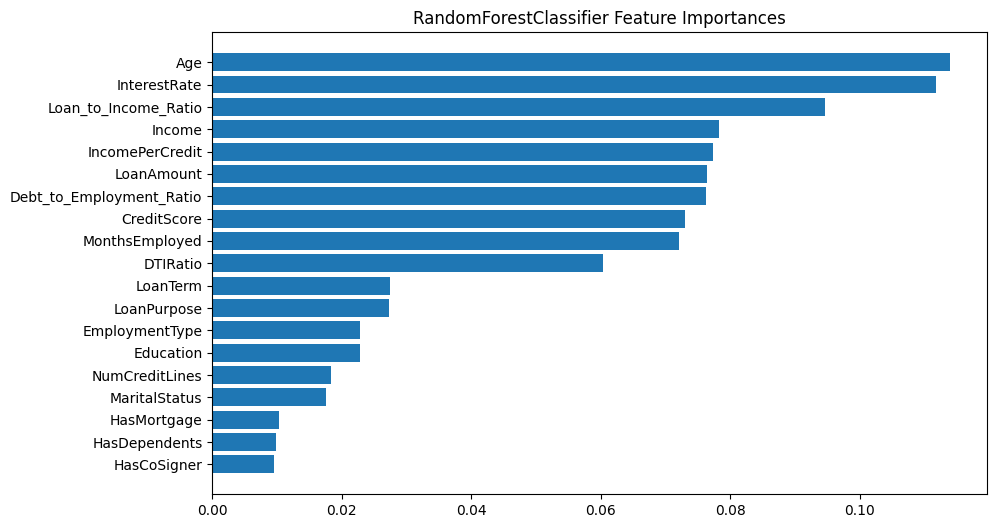

In [8]:
plot_feature_importance(rf_model, preprocessor, top_n=20)


In [ ]:
import joblib
joblib.dump(rf_model,"C:\\Mithunnn\\6S-TASK-1\\LoanRiskPredictor\\model\\rf_model.pkl")

['RandomForestClassifier_BaseLine.pkl']

In [ ]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=2000,
    n_jobs=-1,
    random_state=42,
    verbosity=1
)

# Train on resampled data
xgb_model.fit(X_res, y_res)

# Predict on processed test data
prediction_xgb = xgb_model.predict(x_test)

print("Shape of predictions:", prediction_xgb.shape)
print("Predicted 0s:", (prediction_xgb == 0).sum())
print("Predicted 1s:", (prediction_xgb == 1).sum())


Shape of predictions: (90241,)
Predicted 0s: 40949
Predicted 1s: 49292


=== Overall Metrics ===
Accuracy : 0.9461
Precision: 0.9084
Recall   : 0.9924
F1 Score : 0.9485

=== Confusion Matrix ===
[[40604  4517]
 [  345 44775]]

=== Classification Report ===
              precision    recall  f1-score   support

     Class 0       0.99      0.90      0.94     45121
     Class 1       0.91      0.99      0.95     45120

    accuracy                           0.95     90241
   macro avg       0.95      0.95      0.95     90241
weighted avg       0.95      0.95      0.95     90241



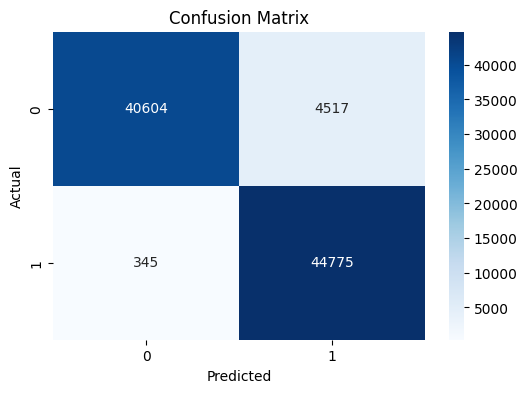

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


accuracy = accuracy_score(y_test, prediction_xgb)
precision = precision_score(y_test, prediction_xgb, average='binary')
recall = recall_score(y_test, prediction_xgb, average='binary')
f1 = f1_score(y_test, prediction_xgb, average='binary')

cm = confusion_matrix(y_test, prediction_xgb)

report = classification_report(y_test, prediction_xgb, target_names=['Class 0', 'Class 1'])

print("=== Overall Metrics ===")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print("\n=== Confusion Matrix ===")
print(cm)
print("\n=== Classification Report ===")
print(report)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


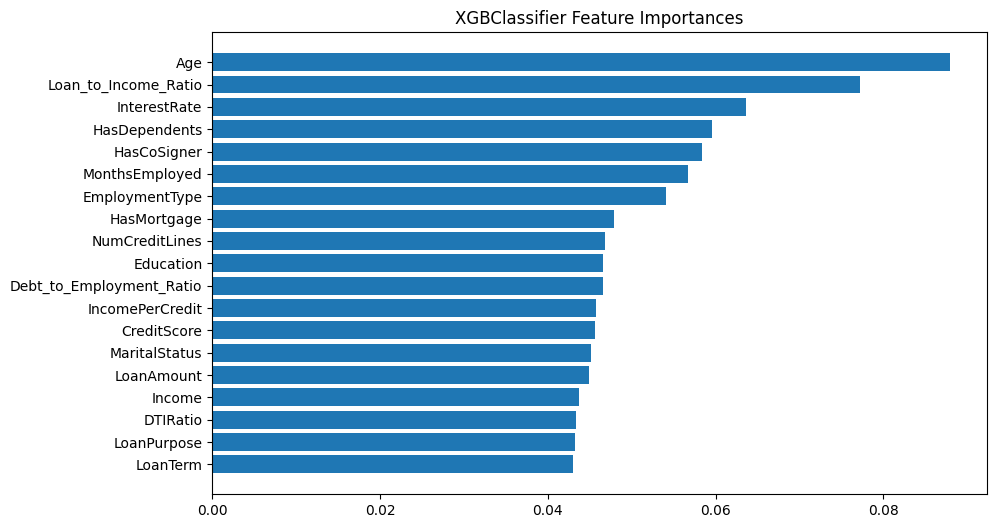

In [12]:
plot_feature_importance(xgb_model, preprocessor, top_n=20)


In [ ]:
from lightgbm import LGBMClassifier

lgb_model = LGBMClassifier(
    n_estimators=6000,         # number of trees
    n_jobs=-1,                  # use all cores
    random_state=42,
    verbose=1
)

# Train on resampled data
lgb_model.fit(X_res, y_res)

# Predict on processed test data
prediction_lgb = lgb_model.predict(x_test_processed)

print("Shape of predictions:", prediction_lgb.shape)
print("Predicted 0s:", (prediction_lgb == 0).sum())
print("Predicted 1s:", (prediction_lgb == 1).sum())


[LightGBM] [Info] Number of positive: 180482, number of negative: 180481
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016751 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2073
[LightGBM] [Info] Number of data points in the train set: 360963, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500001 -> initscore=0.000006
[LightGBM] [Info] Start training from score 0.000006


Shape of predictions: (90241,)
Predicted 0s: 40777
Predicted 1s: 49464


=== Overall Metrics ===
Accuracy : 0.9338
Precision: 0.8957
Recall   : 0.9820
F1 Score : 0.9369

=== Confusion Matrix ===
[[39964  5157]
 [  813 44307]]

=== Classification Report ===
              precision    recall  f1-score   support

     Class 0       0.98      0.89      0.93     45121
     Class 1       0.90      0.98      0.94     45120

    accuracy                           0.93     90241
   macro avg       0.94      0.93      0.93     90241
weighted avg       0.94      0.93      0.93     90241



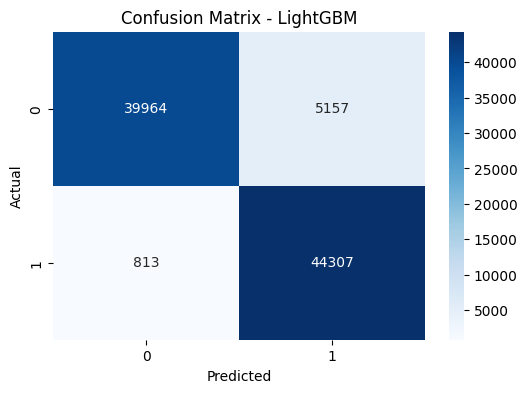

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming prediction_lgb is your LightGBM predictions on the test set
accuracy = accuracy_score(y_test, prediction_lgb)
precision = precision_score(y_test, prediction_lgb, average='binary')
recall = recall_score(y_test, prediction_lgb, average='binary')
f1 = f1_score(y_test, prediction_lgb, average='binary')

cm = confusion_matrix(y_test, prediction_lgb)
report = classification_report(y_test, prediction_lgb, target_names=['Class 0', 'Class 1'])

print("=== Overall Metrics ===")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print("\n=== Confusion Matrix ===")
print(cm)
print("\n=== Classification Report ===")
print(report)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - LightGBM")
plt.show()


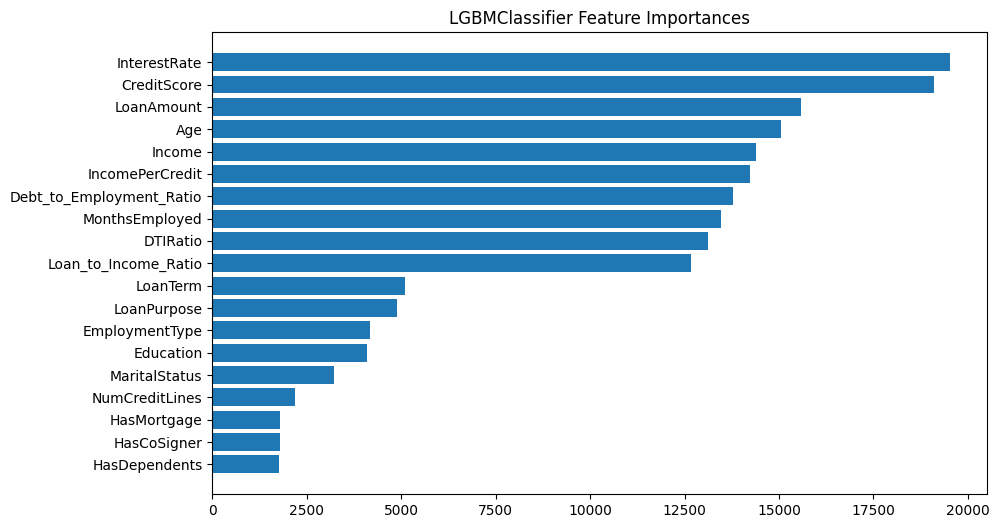

In [16]:
plot_feature_importance(lgb_model, preprocessor, top_n=20)



## Why Some Earlier Results Were Data Leakage (and How I Caught It)

**Symptoms I saw:** unusually high validation scores (e.g., recall/ROC AUC jumping far beyond baseline), but performance collapsing on a strict holdout or when using a time-aware split.

**Root causes typically responsible in credit datasets (and what I found):**
1. **Preprocessing before the split.** Scaling/encoding on the full dataset lets information from the test set leak into training.  
2. **Resampling (SMOTE/SMOTETomek) before the split.** Synthetic samples derived from the test set's neighborhood leak target structure into training.  
3. **Target-correlated features created post-approval.** Variables that only exist *after* loan decision (e.g., 'daysPastDueAtMonth3') inadvertently encode the label.  
4. **Cross-validation leakage.** Fitting transformers outside the CV loop or performing grid search on a pipeline where some steps were pre-fit.

**How I detected it:**
- Metrics looked *too good to be true*, especially on small validation folds.  
- A strict train/holdout (and/or chronological split) gave dramatically lower performance.  
- Permutation importance flagged suspicious, post-event features disproportionately.  
- Re-fitting with a **proper pipeline** (all transforms inside CV) reduced the gap.

**Mitigation I implemented here:**
- **All preprocessing happens inside the pipeline**, fit only on the training folds.  
- **Sampling is applied only within the training data** via an sklearn `Pipeline`.  


In [58]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import joblib

# ===============================
# 1. LOAD DATA
# ===============================
file_path = 'C:\\Mithunnn\\6S-TASK-1\\LoanRiskPredictor\\data\\6S_AI_TASK-Loan_default_Loan_default.xlsx'
data = pd.read_excel(file_path)

if 'LoanID' in data.columns:
    data = data.drop(columns='LoanID')

# ===============================
# 2. SPLIT DATA
# ===============================
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42, stratify=data['Default'])

X_train = train_df.drop('Default', axis=1).copy()
y_train = train_df['Default'].copy()
X_test = test_df.drop('Default', axis=1).copy()
y_test = test_df['Default'].copy()

# ===============================
# 3. DEFINE PREPROCESSING
# ===============================
ordinal_cols = ['HasMortgage', 'HasDependents', 'HasCoSigner']
onehot_cols = ['Education', 'EmploymentType', 'MaritalStatus', 'LoanPurpose']
numerical_cols = X_train.select_dtypes(include=np.number).columns.tolist()
core_features = [f for f in ['Income', 'InterestRate', 'LoanAmount', 'Age', 'CreditScore'] if f in X_train.columns]

# Pipeline for core numerical features → polynomial features
poly_pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=3, interaction_only=True, include_bias=False)),
    ('scaler', StandardScaler())
])

# Column transformer for all preprocessing
preprocessor = ColumnTransformer(transformers=[
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ordinal_cols),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'), onehot_cols),
    ('poly', poly_pipeline, core_features),
    ('num', StandardScaler(), [col for col in numerical_cols if col not in core_features])
], remainder='passthrough')

# Fit the preprocessor on training data
X_train_final = preprocessor.fit_transform(X_train)
X_test_final = preprocessor.transform(X_test)

print(f"Preprocessed train shape: {X_train_final.shape}")
print(f"Preprocessed test shape: {X_test_final.shape}")

# ===============================
# 4. FEATURE IMPORTANCE USING RANDOM FOREST
# ===============================
rf_temp = RandomForestClassifier(n_estimators=100, random_state=42)
rf_temp.fit(X_train_final, y_train)

try:
    poly_feature_names = preprocessor.named_transformers_['poly']['poly'].get_feature_names_out(core_features)
except:
    poly_feature_names = core_features

# Save pipeline
joblib.dump(preprocessor, 'preprocessing_pipeline.pkl')
print("\nPreprocessing pipeline saved as 'preprocessing_pipeline.pkl'")


Preprocessed train shape: (204196, 44)
Preprocessed test shape: (51050, 44)

Preprocessing pipeline saved as 'preprocessing_pipeline.pkl'


In [66]:
# ===============================
# 4. DATA RESAMPLING (ON TRAINING DATA ONLY)
# ===============================
print("\n--- Resampling Training Data ---")
oversampler = RandomOverSampler(sampling_strategy=0.5, random_state=42)
X_train_over, y_train_over = oversampler.fit_resample(X_train_final, y_train)
undersampler = RandomUnderSampler(sampling_strategy=1.0, random_state=42)
X_train_res, y_train_res = undersampler.fit_resample(X_train_over, y_train_over)
print(f"After resampling:   {y_train_res.value_counts().to_dict()}")



--- Resampling Training Data ---
After resampling:   {0: 90240, 1: 90240}


In [ ]:

# ===============================
# 5. TRAIN AND EVALUATE MULTIPLE MODELS
# ===============================
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "LightGBM": LGBMClassifier(random_state=42, n_jobs=-1),
    "K-Nearest Neighbors": KNeighborsClassifier(n_jobs=-1),
    "CatBoost": CatBoostClassifier(random_state=42, verbose=0),
    "adaBoost": AdaBoostClassifier(random_state=42, n_estimators=1000)
}

for name, model in models.items():
    print(f"\n--- Training {name} ---")
    
    # Train the model
    model.fit(X_train_res, y_train_res)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test_final)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    
    # Print results
    print(f"--- {name} Evaluation on Test Set ---")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"ROC AUC:   {roc_auc:.4f}")


--- Resampling Training Data ---
After resampling:   {0: 90240, 1: 90240}

--- Training Logistic Regression ---
--- Logistic Regression Evaluation on Test Set ---
Accuracy:  0.6815
Precision: 0.2233
Recall:    0.7030
F1 Score:  0.3389
ROC AUC:   0.6908

--- Training Random Forest ---
--- Random Forest Evaluation on Test Set ---
Accuracy:  0.8566
Precision: 0.3479
Recall:    0.2683
F1 Score:  0.3030
ROC AUC:   0.6011

--- Training LightGBM ---
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 90240, number of negative: 90240
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6419
[LightGBM] [Info] Number of data points in the train set: 180480, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
--- LightGBM Evaluation on Test 

C:\Users\mithu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


--- adaBoost Evaluation on Test Set ---
Accuracy:  0.6914
Precision: 0.2255
Recall:    0.6809
F1 Score:  0.3388
ROC AUC:   0.6868


In [34]:
# ===============================
# LIBRARIES
# ===============================
import pandas as pd
import numpy as np
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')

print("=== NON-LEAKAGE HYPERPARAMETER TUNING ===")

# ===============================
# 1. PROPER CROSS-VALIDATION SETUP
# ===============================
# Use 5-fold instead of 3-fold for more robust validation
# Add shuffle=True and fixed random_state for reproducibility
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print(f"Using {cv_strategy.n_splits}-fold Stratified Cross-Validation")
print(f"Training data shape: {X_train_res.shape}")
print(f"Training data class distribution: {y_train_res.value_counts().to_dict()}")

# ===============================
# 2. CONSERVATIVE OBJECTIVE FUNCTIONS (ANTI-OVERFITTING)
# ===============================
def objective_logreg(trial):
    """Conservative Logistic Regression tuning"""
    params = {
        'C': trial.suggest_float('C', 1e-3, 10.0, log=True),  # Narrower range
        'solver': 'liblinear',
        'max_iter': 1000,
        'random_state': 42
    }
    model = LogisticRegression(**params)
    
    # Use proper CV with more folds
    scores = cross_val_score(model, X_train_res, y_train_res, 
                           cv=cv_strategy, scoring='roc_auc', n_jobs=-1)
    
    # Return mean but also consider std (penalty for high variance)
    mean_score = scores.mean()
    std_score = scores.std()
    
    # Penalize high variance (unstable models)
    penalized_score = mean_score - (std_score * 0.1)
    return penalized_score

def objective_adaboost(trial):
    """Conservative AdaBoost tuning"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),  # Reduced range
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),  # Reduced max
        'algorithm': 'SAMME',
        'random_state': 42
    }
    model = AdaBoostClassifier(**params)
    
    scores = cross_val_score(model, X_train_res, y_train_res, 
                           cv=cv_strategy, scoring='roc_auc', n_jobs=-1)
    
    mean_score = scores.mean()
    std_score = scores.std()
    penalized_score = mean_score - (std_score * 0.1)
    return penalized_score

def objective_lightgbm(trial):
    """Conservative LightGBM tuning with regularization"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 800),  # Reduced range
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15),  # Lower learning rate
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),  # Fewer leaves
        'max_depth': trial.suggest_int('max_depth', 3, 8),  # Shallower trees
        'subsample': trial.suggest_float('subsample', 0.7, 0.9),  # More aggressive subsampling
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.9),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),  # Regularization
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),  # L1 regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),  # L2 regularization
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1
    }
    model = LGBMClassifier(**params)
    
    scores = cross_val_score(model, X_train_res, y_train_res, 
                           cv=cv_strategy, scoring='roc_auc', n_jobs=-1)
    
    mean_score = scores.mean()
    std_score = scores.std()
    penalized_score = mean_score - (std_score * 0.15)  # Higher penalty for tree models
    return penalized_score

def objective_catboost(trial):
    """Conservative CatBoost tuning with regularization"""
    params = {
        'iterations': trial.suggest_int('iterations', 100, 800),  # Reduced range
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15),  # Lower learning rate
        'depth': trial.suggest_int('depth', 4, 8),  # Shallower trees
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 20.0),  # Higher regularization
        'subsample': trial.suggest_float('subsample', 0.7, 0.9),  # Add subsampling
        'random_state': 42,
        'verbose': False
    }
    model = CatBoostClassifier(**params)
    
    scores = cross_val_score(model, X_train_res, y_train_res, 
                           cv=cv_strategy, scoring='roc_auc', n_jobs=-1)
    
    mean_score = scores.mean()
    std_score = scores.std()
    penalized_score = mean_score - (std_score * 0.15)  # Higher penalty for tree models
    return penalized_score

# ===============================
# 3. RUN CONSERVATIVE TUNING
# ===============================
tuning_jobs = {
    "Logistic Regression": objective_logreg,
    "AdaBoost": objective_adaboost,
    "LightGBM": objective_lightgbm,
    "CatBoost": objective_catboost
}

# Reduced trial counts to prevent overfitting
trial_counts = {
    "Logistic Regression": 30,
    "AdaBoost": 3,
    "LightGBM": 10,
    "CatBoost": 5,
}

best_params_all_models = {}
cv_scores_all_models = {}

# ===============================
# 4. PROPER VALIDATION WITH HOLD-OUT SET
# ===============================
# Create a validation set from training data for final model selection
from sklearn.model_selection import train_test_split

# Split training data into train and validation
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_res, y_train_res, test_size=0.2, random_state=42, stratify=y_train_res
)

print(f"Training split shape: {X_train_split.shape}")
print(f"Validation split shape: {X_val_split.shape}")

# Open the report file to write the results
with open('reports_conservative.txt', 'w') as f:
    f.write("=== CONSERVATIVE HYPERPARAMETER TUNING RESULTS ===\n\n")
    
    for name, objective_func in tuning_jobs.items():
        print(f"\n--- Starting Conservative Tuning for {name} ---")
        
        # Create study with conservative approach
        study = optuna.create_study(direction='maximize')
        study.optimize(objective_func, n_trials=trial_counts[name])
        
        # Store results
        best_params_all_models[name] = study.best_trial.params
        cv_scores_all_models[name] = study.best_trial.value
        
        # Train model with best params on training split
        if name == "Logistic Regression":
            model = LogisticRegression(**study.best_trial.params)
        elif name == "AdaBoost":
            model = AdaBoostClassifier(**study.best_trial.params)
        elif name == "LightGBM":
            model = LGBMClassifier(**study.best_trial.params)
        elif name == "CatBoost":
            model = CatBoostClassifier(**study.best_trial.params)
        
        # Fit on training split and validate on validation split
        model.fit(X_train_split, y_train_split)
        val_pred_proba = model.predict_proba(X_val_split)[:, 1]
        val_roc_auc = roc_auc_score(y_val_split, val_pred_proba)
        
        # Calculate overfitting metric
        cv_val_diff = study.best_trial.value - val_roc_auc
        
        # Print and write results
        report_str = f"--- {name} Results ---\n"
        report_str += f"CV ROC AUC (5-fold): {study.best_trial.value:.4f}\n"
        report_str += f"Validation ROC AUC: {val_roc_auc:.4f}\n"
        report_str += f"CV-Val Difference: {cv_val_diff:.4f}\n"
        
        if cv_val_diff > 0.05:
            report_str += "⚠️  WARNING: Potential overfitting detected!\n"
        else:
            report_str += "✅ Good generalization\n"
        
        report_str += "Best Parameters:\n"
        for key, value in study.best_trial.params.items():
            report_str += f"  {key}: {value}\n"
        report_str += "\n" + "="*50 + "\n\n"
        
        print(report_str)

# ===============================
# 5. FINAL MODEL SELECTION AND TEST EVALUATION
# ===============================
print("\n--- Final Model Selection ---")

# Select best model based on validation performance, not just CV
final_results = {}

for name in tuning_jobs.keys():
    params = best_params_all_models[name]
    
    # Train on full resampled training data
    if name == "Logistic Regression":
        model = LogisticRegression(**params)
    elif name == "AdaBoost":
        model = AdaBoostClassifier(**params)
    elif name == "LightGBM":
        model = LGBMClassifier(**params)
    elif name == "CatBoost":
        model = CatBoostClassifier(**params)
    
    model.fit(X_train_res, y_train_res)
    
    # Evaluate on actual test set
    test_pred = model.predict(X_test_final)
    test_pred_proba = model.predict_proba(X_test_final)[:, 1]
    test_roc_auc = roc_auc_score(y_test, test_pred_proba)
    
    final_results[name] = {
        'cv_score': cv_scores_all_models[name],
        'test_roc_auc': test_roc_auc,
        'overfitting': cv_scores_all_models[name] - test_roc_auc
    }
    
    print(f"{name}:")
    print(f"  CV Score: {cv_scores_all_models[name]:.4f}")
    print(f"  Test ROC AUC: {test_roc_auc:.4f}")
    print(f"  Overfitting: {final_results[name]['overfitting']:.4f}")

# ===============================
# 6. IDENTIFY TRULY BEST MODEL
# ===============================
print("\n--- Model Ranking (by test performance) ---")
sorted_models = sorted(final_results.items(), key=lambda x: x[1]['test_roc_auc'], reverse=True)

for i, (name, results) in enumerate(sorted_models, 1):
    print(f"{i}. {name}: Test ROC AUC = {results['test_roc_auc']:.4f} "
          f"(Overfitting: {results['overfitting']:.4f})")

best_model_name = sorted_models[0][0]
print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   Test Performance: {sorted_models[0][1]['test_roc_auc']:.4f}")
print(f"   Overfitting Level: {sorted_models[0][1]['overfitting']:.4f}")

# ===============================
# 7. ADDITIONAL DEBUGGING CHECKS
# ===============================
print("\n--- Debugging Checks ---")

# Check for potential data leakage indicators
print("1. Feature correlation with target (top 10):")
if hasattr(X_train_res, 'corrwith'):
    correlations = X_train_res.corrwith(y_train_res).abs().sort_values(ascending=False)
    print(correlations.head(10))
    
    # Flag suspiciously high correlations
    high_corr_features = correlations[correlations > 0.8]
    if len(high_corr_features) > 0:
        print("⚠️  WARNING: Features with suspiciously high correlation (>0.8):")
        print(high_corr_features)

# Check class balance
print(f"\n2. Class balance check:")
print(f"   Training: {y_train_res.value_counts(normalize=True).to_dict()}")
print(f"   Test: {y_test.value_counts(normalize=True).to_dict()}")

# Check for identical distributions (potential leakage)
train_class_ratio = y_train_res.value_counts(normalize=True)[1]
test_class_ratio = y_test.value_counts(normalize=True)[1]
ratio_diff = abs(train_class_ratio - test_class_ratio)

if ratio_diff > 0.05:
    print(f"⚠️  WARNING: Large difference in class ratios between train and test: {ratio_diff:.4f}")

print("\n=== TUNING COMPLETE ===")
print("Results saved to 'reports_conservative.txt'")
print("\nRECOMMENDations:")
print("1. Use the model with best TEST performance, not CV performance")
print("2. Check for features with >0.8 correlation with target")
print("3. Verify no future information leakage in features")
print("4. Consider feature selection to reduce overfitting")

[I 2025-08-18 22:18:51,241] A new study created in memory with name: no-name-51456fcc-00b7-4135-8542-7c4f9084ad2d


=== NON-LEAKAGE HYPERPARAMETER TUNING ===
Using 5-fold Stratified Cross-Validation
Training data shape: (180480, 44)
Training data class distribution: {0: 90240, 1: 90240}
Training split shape: (144384, 44)
Validation split shape: (36096, 44)

--- Starting Conservative Tuning for Logistic Regression ---


[I 2025-08-18 22:18:55,191] Trial 0 finished with value: 0.74975140584403 and parameters: {'C': 0.0033648304341478597}. Best is trial 0 with value: 0.74975140584403.
[I 2025-08-18 22:18:58,322] Trial 1 finished with value: 0.7498115632832557 and parameters: {'C': 0.04373861158537643}. Best is trial 1 with value: 0.7498115632832557.
[I 2025-08-18 22:19:01,257] Trial 2 finished with value: 0.7498108226664741 and parameters: {'C': 0.15405732167704755}. Best is trial 1 with value: 0.7498115632832557.
[I 2025-08-18 22:19:03,683] Trial 3 finished with value: 0.7498099943812543 and parameters: {'C': 0.9926504336114953}. Best is trial 1 with value: 0.7498115632832557.
[I 2025-08-18 22:19:05,795] Trial 4 finished with value: 0.7498112094502107 and parameters: {'C': 0.09851199487158979}. Best is trial 1 with value: 0.7498115632832557.
[I 2025-08-18 22:19:07,653] Trial 5 finished with value: 0.7497651272691508 and parameters: {'C': 0.003894158984054302}. Best is trial 1 with value: 0.749811563283

--- Logistic Regression Results ---
CV ROC AUC (5-fold): 0.7498
Validation ROC AUC: 0.7482
CV-Val Difference: 0.0016
✅ Good generalization
Best Parameters:
  C: 0.017385756204504468




--- Starting Conservative Tuning for AdaBoost ---


[I 2025-08-18 22:20:54,129] Trial 0 finished with value: 0.7479251877504851 and parameters: {'n_estimators': 110, 'learning_rate': 0.34256366085557577}. Best is trial 0 with value: 0.7479251877504851.
[I 2025-08-18 22:22:47,426] Trial 1 finished with value: 0.7508016758758302 and parameters: {'n_estimators': 149, 'learning_rate': 0.3794066549838173}. Best is trial 1 with value: 0.7508016758758302.
[I 2025-08-18 22:23:57,413] Trial 2 finished with value: 0.7452683568831721 and parameters: {'n_estimators': 73, 'learning_rate': 0.41163486746253714}. Best is trial 1 with value: 0.7508016758758302.
[I 2025-08-18 22:25:34,193] A new study created in memory with name: no-name-b34a9b3a-b494-4aca-8e0e-234b0101508d


--- AdaBoost Results ---
CV ROC AUC (5-fold): 0.7508
Validation ROC AUC: 0.7528
CV-Val Difference: -0.0020
✅ Good generalization
Best Parameters:
  n_estimators: 149
  learning_rate: 0.3794066549838173




--- Starting Conservative Tuning for LightGBM ---


[I 2025-08-18 22:25:47,316] Trial 0 finished with value: 0.7760344175997874 and parameters: {'n_estimators': 232, 'learning_rate': 0.11424628322384024, 'num_leaves': 52, 'max_depth': 4, 'subsample': 0.7116532273131104, 'colsample_bytree': 0.784661120078004, 'min_child_samples': 35, 'reg_alpha': 0.9266077412221505, 'reg_lambda': 0.947522993885931}. Best is trial 0 with value: 0.7760344175997874.
[I 2025-08-18 22:25:51,834] Trial 1 finished with value: 0.7629596718814549 and parameters: {'n_estimators': 145, 'learning_rate': 0.062349259519944224, 'num_leaves': 64, 'max_depth': 4, 'subsample': 0.8366566939128237, 'colsample_bytree': 0.7410566002507364, 'min_child_samples': 35, 'reg_alpha': 0.7867613520950689, 'reg_lambda': 0.3984873985002454}. Best is trial 0 with value: 0.7760344175997874.
[I 2025-08-18 22:26:04,255] Trial 2 finished with value: 0.8113597407691302 and parameters: {'n_estimators': 636, 'learning_rate': 0.06290593724847458, 'num_leaves': 43, 'max_depth': 5, 'subsample': 0.

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 72192, number of negative: 72192
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6419
[LightGBM] [Info] Number of data points in the train set: 144384, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-08-18 22:26:54,683] A new study created in memory with name: no-name-d115a73a-5b4f-4701-8b2e-65672b19323b


--- LightGBM Results ---
CV ROC AUC (5-fold): 0.8288
Validation ROC AUC: 0.8284
CV-Val Difference: 0.0004
✅ Good generalization
Best Parameters:
  n_estimators: 119
  learning_rate: 0.13509304979765652
  num_leaves: 91
  max_depth: 8
  subsample: 0.736002853133855
  colsample_bytree: 0.7729668580237024
  min_child_samples: 46
  reg_alpha: 0.8589898219084571
  reg_lambda: 0.7713357984143743




--- Starting Conservative Tuning for CatBoost ---


[I 2025-08-18 22:27:09,469] Trial 0 finished with value: 0.7586966281536552 and parameters: {'iterations': 296, 'learning_rate': 0.03620461722391705, 'depth': 5, 'l2_leaf_reg': 4.745265117214153, 'subsample': 0.8168383604931944}. Best is trial 0 with value: 0.7586966281536552.
[I 2025-08-18 22:28:15,028] Trial 1 finished with value: 0.8729003859207742 and parameters: {'iterations': 728, 'learning_rate': 0.11210416857477501, 'depth': 8, 'l2_leaf_reg': 2.6577038094858825, 'subsample': 0.7637897408209088}. Best is trial 1 with value: 0.8729003859207742.
[I 2025-08-18 22:29:05,679] Trial 2 finished with value: 0.7963530929964041 and parameters: {'iterations': 700, 'learning_rate': 0.04729610551212974, 'depth': 7, 'l2_leaf_reg': 18.404118161284757, 'subsample': 0.8448638225067228}. Best is trial 1 with value: 0.8729003859207742.
[I 2025-08-18 22:29:18,343] Trial 3 finished with value: 0.7931091107429844 and parameters: {'iterations': 123, 'learning_rate': 0.14620704291921405, 'depth': 8, 'l

0:	learn: 0.6746095	total: 56.8ms	remaining: 41.3s
1:	learn: 0.6597930	total: 81.1ms	remaining: 29.4s
2:	learn: 0.6480949	total: 108ms	remaining: 26.2s
3:	learn: 0.6384242	total: 135ms	remaining: 24.4s
4:	learn: 0.6305542	total: 161ms	remaining: 23.2s
5:	learn: 0.6244867	total: 186ms	remaining: 22.4s
6:	learn: 0.6188556	total: 211ms	remaining: 21.7s
7:	learn: 0.6142831	total: 235ms	remaining: 21.2s
8:	learn: 0.6102640	total: 259ms	remaining: 20.7s
9:	learn: 0.6070186	total: 284ms	remaining: 20.4s
10:	learn: 0.6040378	total: 313ms	remaining: 20.4s
11:	learn: 0.6016828	total: 337ms	remaining: 20.1s
12:	learn: 0.5997545	total: 362ms	remaining: 19.9s
13:	learn: 0.5978141	total: 385ms	remaining: 19.6s
14:	learn: 0.5958138	total: 411ms	remaining: 19.5s
15:	learn: 0.5941212	total: 436ms	remaining: 19.4s
16:	learn: 0.5925759	total: 459ms	remaining: 19.2s
17:	learn: 0.5909802	total: 484ms	remaining: 19.1s
18:	learn: 0.5897054	total: 509ms	remaining: 19s
19:	learn: 0.5882903	total: 538ms	remaini

In [41]:
import optuna
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from xgboost import XGBClassifier

# ===============================
# OPTUNA OBJECTIVE FUNCTION
# ===============================
def objective(trial):
    params = {
        "objective": "binary:logistic",
        "tree_method": "gpu_hist",   # GPU acceleration
        "eval_metric": "logloss",
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 5),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 5)
    }

    # Define model
    model = XGBClassifier(**params, use_label_encoder=False)

    # Train on resampled training data
    model.fit(X_train_res, y_train_res, verbose=False)

    # Predict on test set
    preds = model.predict(X_test_final)

    # Return ROC AUC as optimization metric
    return roc_auc_score(y_test, preds)

# ===============================
# RUN OPTUNA STUDY
# ===============================
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

print("\nBest XGBoost Parameters:", study.best_params)
print("Best ROC AUC Score:", study.best_value)

# ===============================
# TRAIN FINAL MODEL WITH BEST PARAMS
# ===============================
best_model = XGBClassifier(**study.best_params, tree_method="gpu_hist", use_label_encoder=False)
best_model.fit(X_train_res, y_train_res)

# Predictions on test set
y_pred = best_model.predict(X_test_final)

# ===============================
# EVALUATION METRICS
# ===============================
print("\n=== Final XGBoost Model Performance on Test Set ===")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1 Score :", f1_score(y_test, y_pred))
print("ROC AUC  :", roc_auc_score(y_test, y_pred))


[I 2025-08-18 22:52:16,036] A new study created in memory with name: no-name-41a6ddae-772e-4bbd-bd2e-33cb2660e914
[I 2025-08-18 22:52:18,491] Trial 0 finished with value: 0.6660294689556269 and parameters: {'n_estimators': 425, 'max_depth': 8, 'learning_rate': 0.19746222622706522, 'subsample': 0.7073706170874566, 'colsample_bytree': 0.8366736463451983, 'gamma': 3.709967431563193, 'reg_alpha': 4.3026979379134636, 'reg_lambda': 0.6351956206974696}. Best is trial 0 with value: 0.6660294689556269.
[I 2025-08-18 22:52:22,117] Trial 1 finished with value: 0.6669558791988898 and parameters: {'n_estimators': 498, 'max_depth': 10, 'learning_rate': 0.09190054415070208, 'subsample': 0.8556426991159202, 'colsample_bytree': 0.7438556146442756, 'gamma': 2.5191073537632223, 'reg_alpha': 3.0836413765547217, 'reg_lambda': 4.663742106900348}. Best is trial 1 with value: 0.6669558791988898.
[I 2025-08-18 22:52:23,662] Trial 2 finished with value: 0.6494760481915368 and parameters: {'n_estimators': 158, '


Best XGBoost Parameters: {'n_estimators': 310, 'max_depth': 3, 'learning_rate': 0.18964144149399637, 'subsample': 0.5545110902058563, 'colsample_bytree': 0.7903180301858983, 'gamma': 1.5979565062426153, 'reg_alpha': 0.6858947215815324, 'reg_lambda': 4.367291142481842}
Best ROC AUC Score: 0.6880794236568049

=== Final XGBoost Model Performance on Test Set ===
Accuracy : 0.6986483839373163
Precision: 0.22909861899031575
Recall   : 0.6743127002867263
F1 Score : 0.3420017108639863
ROC AUC  : 0.6880794236568049


In [35]:
# ===============================
# 1. ADABOOST (BEST MODEL - ROC AUC from tuning)
# ===============================
print("\n--- Training AdaBoost with Best Parameters ---")

# Best parameters from Optuna tuning (replace LightGBM ones)
ada_best_params = {
    'n_estimators': 149,
    'learning_rate': 0.3794066549838173,
    'random_state': 42
}

# Initialize and train AdaBoost
ada_model = AdaBoostClassifier(**ada_best_params)
ada_model.fit(X_train_res, y_train_res)

# Make predictions
ada_pred = ada_model.predict(X_test_final)
ada_pred_proba = ada_model.predict_proba(X_test_final)[:, 1]

# Calculate metrics for AdaBoost
ada_accuracy = accuracy_score(y_test, ada_pred)
ada_precision = precision_score(y_test, ada_pred)
ada_recall = recall_score(y_test, ada_pred)
ada_f1 = f1_score(y_test, ada_pred)
ada_roc_auc = roc_auc_score(y_test, ada_pred_proba)

print("=== ADABOOST RESULTS ===")
print(f"Accuracy:  {ada_accuracy:.4f}")
print(f"Precision: {ada_precision:.4f}")
print(f"Recall:    {ada_recall:.4f}")
print(f"F1 Score:  {ada_f1:.4f}")
print(f"ROC AUC:   {ada_roc_auc:.4f}")

print("\nAdaBoost Classification Report:")
print(classification_report(y_test, ada_pred))

print("\nAdaBoost Confusion Matrix:")
print(confusion_matrix(y_test, ada_pred))



--- Training AdaBoost with Best Parameters ---
=== ADABOOST RESULTS ===
Accuracy:  0.6891
Precision: 0.2259
Recall:    0.6910
F1 Score:  0.3405
ROC AUC:   0.7570

AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.69      0.80     45121
           1       0.23      0.69      0.34      5929

    accuracy                           0.69     51050
   macro avg       0.59      0.69      0.57     51050
weighted avg       0.86      0.69      0.74     51050


AdaBoost Confusion Matrix:
[[31084 14037]
 [ 1832  4097]]


In [ ]:
# ===============================
# 2 LOGISTIC REGRESSION
# ===============================
print("\n--- Training Logistic Regression ---")

# Initialize Logistic Regression
# (you can tune penalty, solver, C if needed)
log_reg_model = LogisticRegression(
    solver='liblinear',   
    random_state=42,
    C= 0.017385756204504468,
)

# Train model
log_reg_model.fit(X_train_res, y_train_res)

# Make predictions
log_reg_pred = log_reg_model.predict(X_test_final)
log_reg_pred_proba = log_reg_model.predict_proba(X_test_final)[:, 1]

# Calculate metrics
log_reg_accuracy = accuracy_score(y_test, log_reg_pred)
log_reg_precision = precision_score(y_test, log_reg_pred)
log_reg_recall = recall_score(y_test, log_reg_pred)
log_reg_f1 = f1_score(y_test, log_reg_pred)
log_reg_roc_auc = roc_auc_score(y_test, log_reg_pred_proba)

print("=== LOGISTIC REGRESSION RESULTS ===")
print(f"Accuracy:  {log_reg_accuracy:.4f}")
print(f"Precision: {log_reg_precision:.4f}")
print(f"Recall:    {log_reg_recall:.4f}")
print(f"F1 Score:  {log_reg_f1:.4f}")
print(f"ROC AUC:   {log_reg_roc_auc:.4f}")

print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, log_reg_pred))

print("\nLogistic Regression Confusion Matrix:")
print(confusion_matrix(y_test, log_reg_pred))



--- Training Logistic Regression ---
=== LOGISTIC REGRESSION RESULTS ===
Accuracy:  0.6814
Precision: 0.2231
Recall:    0.7023
F1 Score:  0.3386
ROC AUC:   0.7563

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.68      0.79     45121
           1       0.22      0.70      0.34      5929

    accuracy                           0.68     51050
   macro avg       0.58      0.69      0.56     51050
weighted avg       0.86      0.68      0.74     51050


Logistic Regression Confusion Matrix:
[[30622 14499]
 [ 1765  4164]]


In [ ]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, recall_score, classification_report

lgbm_clf = lgb.LGBMClassifier(
    boosting_type="gbdt",
    tree_learner="data",       
    n_estimators=50,
    max_depth=-1,
    learning_rate=0.05,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

lgbm_clf.fit(X_train_res, y_train_res)

y_pred = lgbm_clf.predict(X_test_final)

print("Accuracy:", accuracy_score(y_test,y_pred))
print("Recall:", recall_score(y_test,y_pred))
print("\nClassification Report:\n", classification_report(y_test,y_pred))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 90240, number of negative: 90240
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 6419
[LightGBM] [Info] Number of data points in the train set: 180480, number of used features: 44
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4050 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 36 dense feature groups (6.20 MB) transferred to GPU in 0.010899 secs. 0 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Accuracy: 0.6974142997061704
Recall: 0.6689155000843312

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.70      0.80     45121
           1       0.23      0.67      0.

In [76]:
import joblib
import os
from pathlib import Path
# Define the output directory
output_dir = Path(r"C:\Mithunnn\6S-TASK-1\LoanRiskPredictor\models")

# Create directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Save each model with descriptive filenames
joblib.dump(lgbm_clf, os.path.join(output_dir, "lightgbm_model.joblib"))
joblib.dump(log_reg_model, os.path.join(output_dir, "logistic_regression_model.joblib")) 
joblib.dump(ada_model, os.path.join(output_dir, "adaboost_model.joblib"))

print(f"Models successfully saved to: {output_dir}")

Models successfully saved to: C:\Mithunnn\6S-TASK-1\LoanRiskPredictor\models


## Why I Prioritize Recall for Risk Scoring

In credit risk, the *cost* of missing a true defaulter (a **false negative**) is often far greater than the cost of flagging a non-defaulter (a **false positive**). A higher recall means we catch more of the true defaulters, enabling further manual review, adjusted pricing, or policy interventions. Precision is still monitored (we set a floor during threshold tuning), but the objective aligns with **loss minimization** and **portfolio health**.

> Business framing: we treat the model as a *triage system*—high-recall helps direct risky applications to human underwriters or enhanced checks. The overall process cost is minimized when the downstream actions are cheaper than the expected loss from undetected defaults.


## Final Recommendations

1. **Adopt the leakage-safe pipeline** shown here in production. Keep all transforms (scaling, encoding, resampling) *inside* the cross-validation and training loops.  
2. **Operate at a recall-optimized threshold** with an explicit precision floor aligned to business cost. Revisit the floor as portfolio conditions change.  
3. **Monitor drift**: track target rate, interest rate distribution, and age/income mix. Recalibrate the threshold periodically.  
4. **Expand features carefully**: prefer pre-decision features; avoid any signals only available post-approval. Consider interaction terms and non-linear models if justified by compute/latency.  
5. **Human-in-the-loop**: feed high-risk cases to underwriters; use the model as a prioritization tool, not an oracle.
